# Denoising with BM3D

The code below demonstrates the denoising performance on an example image.

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os

import warnings
warnings.filterwarnings('ignore')

from include import *
from PIL import Image
import PIL

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable

import pybm3d

GPU = False
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '6'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor


## Generate noisy image

In [2]:
def get_noisy_img(img_np,sig=30,noise_same = False):
    sigma = sig/255.
    if noise_same: # add the same noise in each channel
        noise = np.random.normal(scale=sigma, size=img_np.shape[1:])
        noise = np.array( [noise]*img_np.shape[0] )
    else: # add independent noise in each channel
        noise = np.random.normal(scale=sigma, size=img_np.shape)

    img_noisy_np = np.clip( img_np + noise , 0, 1).astype(np.float32)
    #img_noisy_var = np_to_var(img_noisy_np).type(dtype)
    return img_noisy_np #,img_noisy_var

## Denoise noisy image

In [3]:
sig = 25.0

In [4]:
path = './test_data/'
img_name = "astronaut"
#img_name = "mri"

img_path = path + img_name + ".png"
img_pil = Image.open(img_path)
#img_pil = load_and_crop(img_path,target_width=256,target_height=256)

img_clean_np = pil_to_np(img_pil)
img_clean_var = np_to_var(img_clean_np).type(dtype)

In [5]:
sig = 30.0
noise_same = False
img_noisy_np = get_noisy_img(img_clean_np,sig,noise_same)

In [6]:
sigma = sig/255.
img_noisy_np = img_noisy_np.transpose(1,2,0)
out_img_np = pybm3d.bm3d.bm3d(img_noisy_np, sigma)
img_noisy_np = img_noisy_np.transpose(2,0,1)

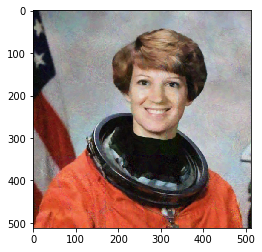

In [7]:
out_img_np = out_img_np.transpose(2,0,1)

myimgshow(plt,out_img_np)
plt.show()

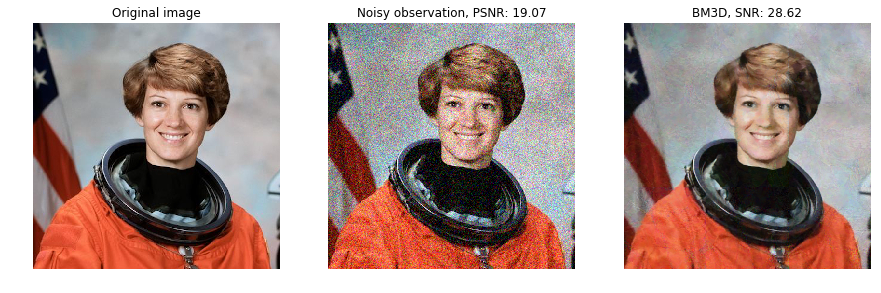

In [8]:
def plot_results():
    fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
    
    ax1 = fig.add_subplot(231)
    myimgshow(ax1,img_clean_np) 
    ax1.set_title('Original image')
    ax1.axis('off')
    
    ax2 = fig.add_subplot(232)
    myimgshow(ax2,img_noisy_np)
    ax2.set_title( "Noisy observation, PSNR: %.2f" % psnr(img_clean_np,img_noisy_np) )
    ax2.axis('off')

    ax3 = fig.add_subplot(233)
    myimgshow(ax3,out_img_np)
    ax3.set_title( "BM3D, SNR: %.2f" % psnr(img_clean_np,out_img_np) ) 
    ax3.axis('off')
    
plot_results()

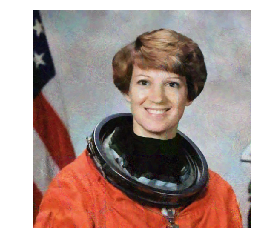

In [9]:
def savefig(filename,img):
    plt.imshow(np.clip(img.transpose(1, 2, 0),0,1),interpolation='none')
    #plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.savefig(filename,bbox_inches='tight')
    
savefig(img_name + "_bm3d.png",out_img_np)